In [12]:
#imports

# import random
import pandas as pd
import numpy as np
import pickle
import pygmo as pg
import matplotlib.pyplot as plt
import seaborn as sns


# # Own Model import
from lib.fl_model_v9 import *
import lib
# # import lib.fl_model_v5 as flm

# # for natural sorting
import re

# #for nondominated sorting
import lib.pareto as pareto
# # from lib.list_imports import find_loaded_modules

# # for parallel plotting
# from lib.parallel_plotting import plot_optimal

# # For checking ema running time
# import time

# import importlib

# import geopy
# from geopy.distance import great_circle 

In [2]:
case = "Nepal"
output_folder = "MPMORDM Results v1 2015"

## Load Data for reevaluation of policies under perfect information

In [3]:
Fix_Unc = pd.read_csv("{}/Prepared Input Data/fixed_uncertainties.csv".format(case), index_col=0)

DPs = pd.read_csv("{}/Prepared Input Data/DPs.csv".format(case))
# DPs.columns

FLs = pd.read_csv("{}/Prepared Input Data/FLs.csv".format(case))
# FLs.columns

SPs = pd.read_csv("{}/Prepared Input Data/SPs.csv".format(case))
# SPs.columns

# 0. Instantiate

# General
# Coordinates
# all large cities to demand points
DPY = {"DPY{}".format(i): y for i,y in enumerate(DPs['latitude'])}
DPX = {"DPX{}".format(i): x for i,x in enumerate(DPs['longitude'])}

# all international airports to supply points:
SPY = {"SPY{}".format(i): y for i,y in enumerate(SPs['latitude_deg'])}
SPX = {"SPX{}".format(i): x for i,x in enumerate(SPs['longitude_deg'])}

# Facility locations
FLX = {"FLX{}".format(i): x for i,x in enumerate(FLs['Lon'])}
FLY = {"FLY{}".format(i): y for i,y in enumerate(FLs['Lat'])}


# Population demand points
DPpop = {"DPpop{}".format(i): pop for i,pop in enumerate(DPs['population'])}


In [4]:
Fix_Unc

,lower,best_estimate,upper
var,,,
unit_opening_costs,50.0,100,200
unit_transport_cost,0.5,1,2
FL_operations_cost,20.0,30,50
FL_range,2.0,4,6
demand_per_affected,10.0,20,50


In [5]:
epicentre_name = "RealLocation"
print("Pick right Epicentre, and/or load disruption data.\n",
      "Epicentre chosen: {}".format(epicentre_name))

Pick right Epicentre, and/or load disruption data.
 Epicentre chosen: RealLocation


In [6]:
disruptionsFLs = np.loadtxt(
    'Nepal/Prepared Input Data/DisruptionFL{}.txt'.format(epicentre_name))
disruptionsDPs = np.loadtxt(
    'Nepal/Prepared Input Data/DisruptionDP{}.txt'.format(epicentre_name))

In [7]:
# Base real values on Nepal earthquake
# DSR is abbreviation for Disruption

DSRDP = {"DSRDP{}".format(i): disruptionsDPs[i] for i in range(len(DPX))}
DSRFL = {"DSRFL{}".format(i): disruptionsFLs[i] for i in range(len(FLX))}

## Create MOO results for perfect information

In [8]:
from itertools import product
# Create All possible policies
start_situation = {key: 0 for key in FLs.Name}

# Create all possible permutations for
permutations = [i for i in product([0, 1], repeat=len(FLs)) if sum(i) == 4]
print(
    "There are {} possible solutions, where there are four different facility locations operational".
    format(len(permutations)))

# Convert possible permutations to policies
All_optional_pols = []
for p in permutations:
    tmp = {"FLO{}".format(i):val for i,val in enumerate(p)}
    All_optional_pols.append(tmp)

There are 4845 possible solutions, where there are four different facility locations operational


In [9]:
# Evaluate all optional policies with best estimate values
Perfect_Info_Results = []
for policy in All_optional_pols:
    Perfect_Info_Results.append(
        FL_model(
            unit_opening_costs=Fix_Unc.best_estimate['unit_opening_costs'],
            unit_transport_cost=Fix_Unc.best_estimate['unit_transport_cost'],
            FL_operations_cost=Fix_Unc.best_estimate['FL_operations_cost'],
            demand_per_affected=Fix_Unc.best_estimate['demand_per_affected'],
            graphical_representation=False,
            FL_range=Fix_Unc.best_estimate['FL_range'],
            dist_method='from_table',
            table_dir="{}/Prepared Input Data/routing_table.csv".format(case),
            **SPX,
            **SPY,
            **DPX,
            **DPY,
            **FLX,
            **FLY,
            **policy,
            **DSRDP,
            **DSRFL,
            **DPpop))

### Find Pareto Front for Perfect Infomration

In [10]:
#Filter out those where the constraint is not satisfied

# outcome indicators, as internally used by the model
oois = [
    'total_costs', 'nr_uncovered_DPs', 'total_uncovered_demand',
    'max_travel_time'
]
# Put outcomes in DF

DF_Perfect_Info_Results = pd.DataFrame(
    np.asarray(Perfect_Info_Results)[:, :5], columns=oois + ["constraint"])
# DF_Perfect_Info_Results.tail()

DF_Perfect_Info_Results_filtered = DF_Perfect_Info_Results[
    DF_Perfect_Info_Results.constraint]
print("There are {} solutions remaining after filtering for the constraint".
      format(DF_Perfect_Info_Results_filtered.shape[0]))
DF_Perfect_Info_Results_filtered.head()

There are 1494 solutions remaining after filtering for the constraint


,total_costs,nr_uncovered_DPs,total_uncovered_demand,max_travel_time,constraint
3,47450.1,21,14245.9,60234,True
7,29812.6,23,15821.2,59777.4,True
10,46581.4,22,14259.1,59777.4,True
12,47386.8,21,14245.9,59777.4,True
14,43289.6,22,14391.7,79058,True


In [13]:
# Get Pareto Front by NonDominated Sorting
PF_MOO = np.array(pareto.eps_sort(
    [list(DF_Perfect_Info_Results_filtered.itertuples(index=True))], [1, 2, 3, 4],
    [1e-9, 1e-9, 1e-9, 1e-9]))

DF_PF_MOO = pd.DataFrame(PF_MOO).set_index(0)
print("There are {} solutions in the pareto front for Perfect Information".
      format(DF_PF_MOO.shape[0]))

There are 72 solutions in the pareto front for Perfect Information


In [14]:
DF_PF_MOO

,1,2,3,4,5
0,,,,,
12.0,47386.756619,21.0,14245.853058,59777.420000,1.0
48.0,210170.847036,14.0,4799.795364,45920.157395,1.0
51.0,226939.584329,13.0,3237.671494,45920.157395,1.0
58.0,222228.415819,12.0,4072.727679,45920.157395,1.0
93.0,65039.834230,17.0,12247.090789,45920.157395,1.0
123.0,229031.638499,10.0,2636.069728,70583.514874,1.0
343.0,48587.279053,19.0,13826.145849,59777.420000,1.0
368.0,231778.331142,10.0,2804.762692,45920.157395,1.0
375.0,228140.106763,11.0,2817.964284,45920.157395,1.0


## Load mpmordm results

In [15]:
with open('{}/{}/python_objects.pickle'.format(case, output_folder),
          'rb') as handle:
    global_label_tree, EMA_model_dict, global_dfs_var_unc_data, global_fixed_unc, global_policy_tree = pickle.load(
        handle)

## Reevaluate MPMORDM results for perfect information

In [16]:
p4_labels = global_label_tree['p4']

In [17]:
p4_pols = [global_policy_tree[label] for label in p4_labels]

In [18]:
print("P4 after Multi-Period Robust Optimisation contains {} number of policies".format(len(p4_pols)))

P4 after Multi-Period Robust Optimisation contains 1376 number of policies


In [19]:
# Filter to find only unique policies

In [20]:
p4_FLs = np.array([[int(key[3:]) for key, value in pol.items() if value == 1]
                   for pol in p4_pols])
p4_FLs = np.unique(p4_FLs, axis=0)
print("Of all {} policies, {} are unique, the rest are duplicates".format(
    len(p4_pols), p4_FLs.shape[0]))

Of all 1376 policies, 207 are unique, the rest are duplicates


In [21]:
p4_pols_unique = [{
    "FLO{}".format(i): 1 if i in p4_FLs[j] else 0
    for i in range(len(p4_pols[0].keys()))
} for j in range(len(p4_FLs))]

In [27]:
# Evaluate all unique policies with best estimate values
MPMORDMpols_for_real_values_results = []
# for policy in p4_pols_unique:
for policy in p4_pols:    
    MPMORDMpols_for_real_values_results.append(
        FL_model(
            unit_opening_costs=Fix_Unc.best_estimate['unit_opening_costs'],
            unit_transport_cost=Fix_Unc.best_estimate['unit_transport_cost'],
            FL_operations_cost=Fix_Unc.best_estimate['FL_operations_cost'],
            demand_per_affected=Fix_Unc.best_estimate['demand_per_affected'],
            graphical_representation=False,
            FL_range=Fix_Unc.best_estimate['FL_range'],
            dist_method='from_table',
            table_dir="{}/Prepared Input Data/routing_table.csv".format(case),
            **SPX,
            **SPY,
            **DPX,
            **DPY,
            **FLX,
            **FLY,
            **policy,
            **DSRDP,
            **DSRFL,
            **DPpop))

### Pareto Front MPMORDM: Dynamic Uncertainty 

In [28]:
#Filter out those where the constraint is not satisfied

# outcome indicators, as internally used by the model
oois = [
    'total_costs', 'nr_uncovered_DPs', 'total_uncovered_demand',
    'max_travel_time'
]
# Put outcomes in DF

DF_MPMORDMpols_for_real_values_results = pd.DataFrame(
    np.asarray(MPMORDMpols_for_real_values_results)[:, :5], columns=oois + ["constraint"])


DF_MPMORDMpols_for_real_values_results_filtered = DF_MPMORDMpols_for_real_values_results[
    DF_MPMORDMpols_for_real_values_results.constraint]
print("There are {} solutions remaining after filtering for the constraint".
      format(DF_MPMORDMpols_for_real_values_results_filtered.shape[0]))
DF_MPMORDMpols_for_real_values_results_filtered.head()

There are 1376 solutions remaining after filtering for the constraint


,total_costs,nr_uncovered_DPs,total_uncovered_demand,max_travel_time,constraint
0,118502,14,10731.9,53409.1,True
1,121687,13,10718.7,53409.1,True
2,272084,13,10586,40806.7,True
3,119705,15,10735.4,53409.1,True
4,122890,14,10722.2,53409.1,True


This is expected, because they already had to satisfy for the constraint during the mpmordm cycle

In [29]:
# Get Pareto Front by NonDominated Sorting
PF_MPMORDM = np.array(pareto.eps_sort(
    [list(DF_MPMORDMpols_for_real_values_results_filtered.itertuples(index=True))], [1, 2, 3, 4],
    [1e-9, 1e-9, 1e-9, 1e-9]))

DF_PF_MPMORDM = pd.DataFrame(PF_MPMORDM).set_index(0)
print("There are {} solutions in the pareto front for Perfect Information".
      format(DF_PF_MPMORDM.shape[0]))

There are 68 solutions in the pareto front for Perfect Information


## Compare Pareto Fronts 

In [30]:
DF_PF_MPMORDM.shape

(68, 5)

In [31]:
DF_PF_MOO.shape

(72, 5)

In [ ]:
pg

### Normalise Old

In [74]:
def normalise_df (df):
    df = df.iloc[:,:4]
    normalised_df=(df-df.min())/(df.max()-df.min())
    return normalised_df

In [105]:
DF_PF_MOO_normalised = normalise_df(DF_PF_MOO.iloc[:,:4])

In [106]:
DF_PF_MPMORDM_normalised = normalise_df(DF_PF_MPMORDM.iloc[:,:4])

### Normalise New

Was wrong, but Didn't make a difference as both min and max values were equal

In [94]:
def normalise_dfs(df1,df2):
    tmp = pd.DataFrame()
    tmp1 = pd.DataFrame(df1.values)
    tmp2 = pd.DataFrame(df2.values)
    tmp = tmp1.append(tmp2)#.reset_index(drop=True)
    
    tmp_normalised = normalise_df(tmp)
    tmp_normalised['dfname'] = tmp.iloc[:,4]
    #set back to different dfs
    df1_normalised = tmp_normalised[tmp_normalised.dfname == df1.dfname.iloc[0]]
    df2_normalised = tmp_normalised[tmp_normalised.dfname == df2.dfname.iloc[0]]
    #set back indexes
    df1_normalised.index = df1.index
    df2_normalised.index = df2.index
    return df1_normalised,df2_normalised
#     pass

In [60]:
DF_PF_MOO['dfname'] = 'MOO'

In [113]:
DF_PF_MOO.min()

total_costs               26690.9
nr_uncovered_DPs                5
total_uncovered_demand    246.426
max_travel_time           27851.3
dfname                        MOO
dtype: object

In [59]:
DF_PF_MPMORDM['dfname'] = 'MPMORDM'

In [112]:
DF_PF_MPMORDM.min()

1         26690.9
2               5
3         246.426
4         27851.3
dfname    MPMORDM
dtype: object

In [100]:
DF_PF_MPMORDM.head()

,1,2,3,4,dfname
0,,,,,
244.0,254010.006208,14.0,21653.465661,33886.375193,MPMORDM
530.0,103742.110580,13.0,10003.337274,53409.117993,MPMORDM
534.0,60851.475156,19.0,12406.182096,70488.224518,MPMORDM
560.0,260930.692169,8.0,1828.974165,53409.117993,MPMORDM
563.0,230113.620689,11.0,2649.271320,70488.224518,MPMORDM


In [87]:
DF_PF_MPMORDM.dfname.iloc[0]

'MPMORDM'

In [101]:
DF_PF_MOO_norm, DF_PF_MPMORDM_norm = normalise_dfs(DF_PF_MOO, DF_PF_MPMORDM)

### Calculate Hypervolume 

In [136]:
ref_point = [1,1,1,1]

In [142]:
hv_MOO = pg.hypervolume(DF_PF_MOO_normalised.values)
# hv_MOO = pg.hypervolume(DF_PF_MOO_norm.iloc[:,:4].astype(float).values)

In [141]:
hv_MOO.compute(ref_point)

0.5105858833019313

In [147]:
hv_MPMORDM = pg.hypervolume(DF_PF_MPMORDM_normalised.values)
# hv_MPMORDM = pg.hypervolume(DF_PF_MPMORDM_norm.iloc[:,:4].astype(float).values)

In [148]:
hv_MPMORDM.compute(ref_point)

0.5105584579890514

In [149]:
diff = hv_MOO.compute(ref_point) - hv_MPMORDM.compute(ref_point)

In [150]:
diff

2.742531287991401e-05

In [138]:
(diff*100 )/ a

0.00537134178143665

## Percentage of MPMORDM solutions in Perfect Info Pareto Front

In [140]:
len(p4_pols)

1376

In [143]:
p4_FLs = np.array([[int(key[3:]) for key, value in pol.items() if value == 1]
                   for pol in p4_pols])

In [144]:
p4_FLs.shape

(1376, 4)

In [220]:
PFMOOPols = np.array(All_optional_pols)[list(DF_PF_MOO.index.astype(int))]

In [221]:
PFMOOPols.shape

(72,)

In [222]:
PFMOO_FLS = np.array([[int(key[3:]) for key, value in pol.items() if value == 1]
                   for pol in PFMOOPols])

In [226]:
PFMOO_FLS.shape

(72, 4)

In [253]:
# Do tolist, because then it checks if full list is in the list of lists.
# Otherwise it checks whether all numbers are in the list or sth. 
sum([fls.tolist() in PFMOO_FLS.tolist() for fls in p4_FLs])

692

## Compare Distributions

In [32]:
# Results for Perfect Information
DF_PF_MOO = DF_PF_MOO.iloc[:,:4]
DF_PF_MOO.columns = oois
DF_PF_MOO.shape


(72, 4)

In [33]:
# Results for MPMORDM
DF_P4_MPMORDM_results = DF_MPMORDMpols_for_real_values_results_filtered.iloc[:,:4]
DF_P4_MPMORDM_results.columns = oois
DF_P4_MPMORDM_results.shape

(1376, 4)

In [34]:
DF_PF_MOO[obj].mean()



NameError: name 'obj' is not defined

In [466]:
DF_P4_MPMORDM_results[obj].astype(float).mean()


56658.908807492524

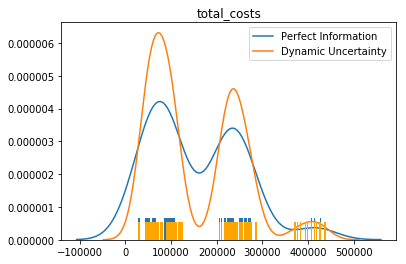

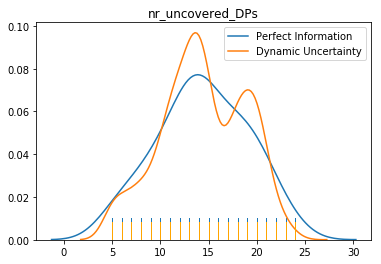

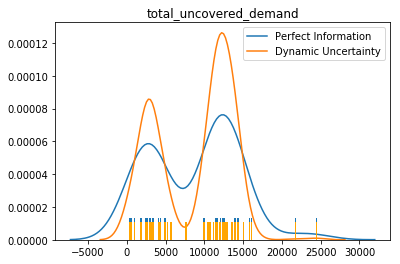

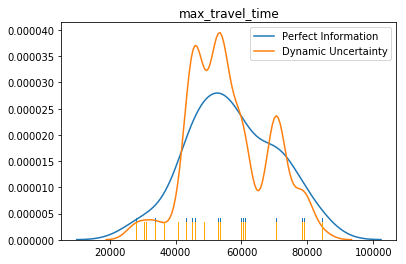

In [35]:
for obj in DF_PF_MOO.columns:
#     f = 
    sns.kdeplot(DF_PF_MOO[obj], label="Perfect Information",)
    sns.rugplot(DF_PF_MOO[obj],height=0.1)
    
    sns.kdeplot(DF_P4_MPMORDM_results[obj], label='Dynamic Uncertainty')
    sns.rugplot(DF_P4_MPMORDM_results[obj], height=0.08, color='orange')
    
    plt.title(obj)
    plt.show()

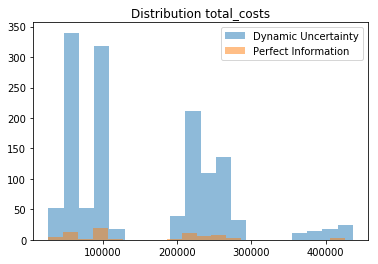

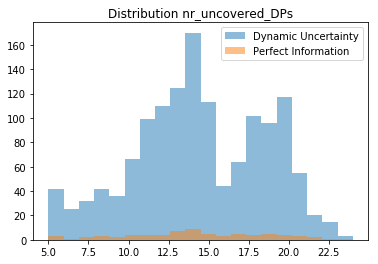

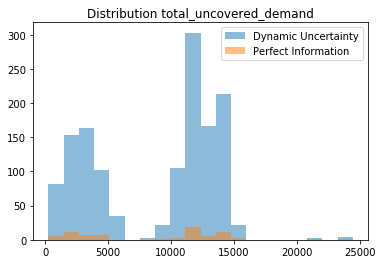

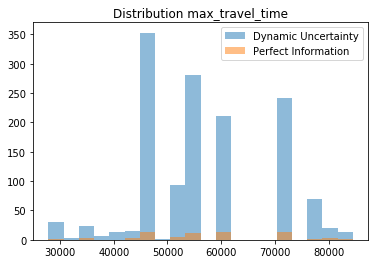

In [36]:
for obj in DF_PF_MOO.columns:
    plt.hist(
        DF_P4_MPMORDM_results[obj].astype(float),
        bins=20,
        alpha=0.5,
        label='Dynamic Uncertainty')
    plt.hist(DF_PF_MOO[obj], bins=20, alpha=0.5, label='Perfect Information')
    plt.legend(loc='upper right')
    plt.title('Distribution {}'.format(obj))
    plt.show()

In [439]:
a = DF_P4_MPMORDM_results[obj].astype(float)

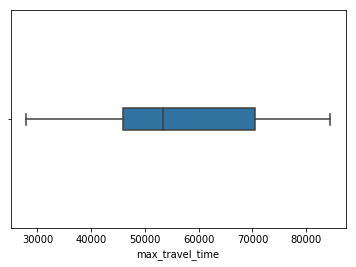

In [449]:
sns.boxplot(a, orient='h',width=0.1)
# plt.boxplot(a,vert=False)
plt.show()